In [15]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
import math


import scipy 

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def create_ellipse(D, N, sample_point):
    scale = sample_point.T @ D @ sample_point
    X = np.random.normal(size=(2, N)) 
    X = X / jnp.linalg.norm(X, axis=0) * jnp.sqrt(scale)
    ellipse = jnp.linalg.inv(jnp.sqrt(D)) @ X
    return scale, ellipse

In [17]:
def get_mc_loss(F, x_0, num_runs):
    g_F = F.f1(x_0)
    def helper(grad_getter, jrandom_key):
        errs = []
        for _ in range(num_runs):
            jrandom_key, subkey = jrandom.split(jrandom_key)
            sgd = grad_getter.grad(F, x_0, subkey, H=F.f2(x_0))[0]
            errs.append(float(jnp.linalg.norm(sgd - g_F)**2))
        errs = jnp.array(errs)
        return jnp.mean(errs), jnp.std(errs), jnp.percentile(errs, 25), jnp.percentile(errs, 75)
    return helper

0.0030453827438275778


(DeviceArray(0.004405, dtype=float64),
 DeviceArray(0.00328207, dtype=float64),
 DeviceArray(0.00237481, dtype=float64),
 DeviceArray(0.00446752, dtype=float64))

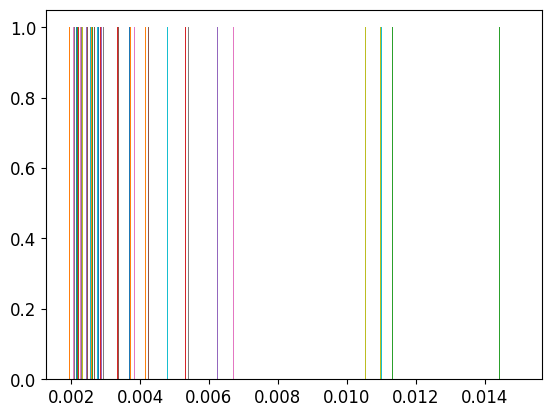

In [57]:
D = jnp.array([[1e-3, 0], [0, 1]])

jrandom_key, subkey = jrandom.split(jrandom_key)

F = Quadratic(1/2 * D, jnp.zeros(2), 0, sig=sig)

l = get_mc_loss(F, x_0, 50)

S_ours = Ours(sig, max_h=float("inf"))
S_FD = FD(sig, is_central=False, h=float("inf"), use_H=True)

l(S_ours, jrandom_key)

# Create 2D plots

In [24]:
sig = 0.1

jrandom_key = jrandom.PRNGKey(0)

x_0 = jnp.ones(2)
res = []

a_range = jnp.logspace(-4, 4, 25)

num_MC = 50

for a in tqdm(a_range):
    D = jnp.array([[a*1, 0], [0, 1]])
    
    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    F = Quadratic(1/2 * D, jnp.zeros(2), 0, sig=sig)
    
    l = get_mc_loss(F, x_0, num_MC)
    
    S_ours = Ours(sig, max_h=float("inf"))
    S_FD = FD(sig, is_central=False, h=float("inf"), use_H=True)

    res.append([l(S_ours, jrandom_key), l(S_FD, jrandom_key)])

    
res = jnp.array(res)



100%|███████████████████████████████████████████| 25/25 [00:30<00:00,  1.22s/it]


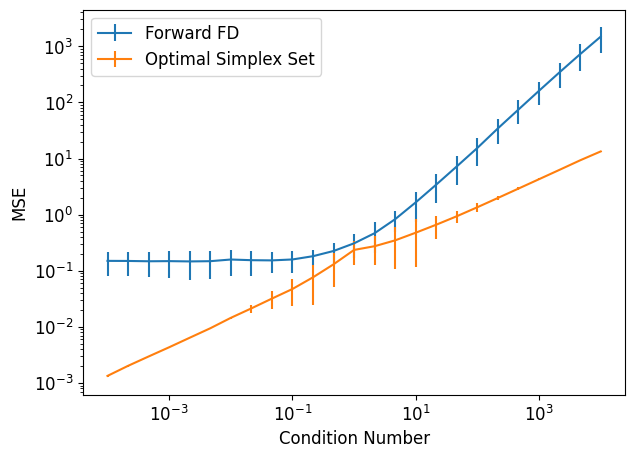

In [25]:
plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Condition Number")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_2d_Error.jpeg".format(sig, num_MC), dpi=500)
plt.show()


# Visualization

0.02
MC ours (DeviceArray(0.04011189, dtype=float64), DeviceArray(0.02003945, dtype=float64), DeviceArray(0.02609735, dtype=float64), DeviceArray(0.04919624, dtype=float64))
MC FD (DeviceArray(0.2914568, dtype=float64), DeviceArray(0.27620385, dtype=float64), DeviceArray(0.07590532, dtype=float64), DeviceArray(0.44621697, dtype=float64))


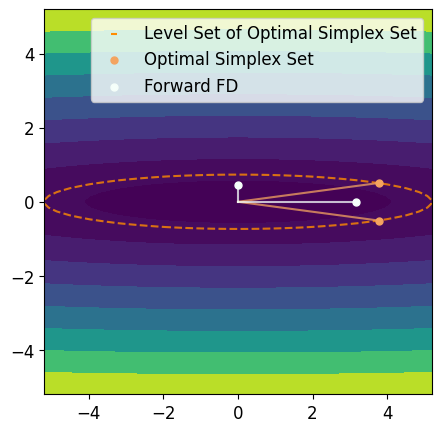

1
MC ours (DeviceArray(0.4997272, dtype=float64), DeviceArray(0.41178298, dtype=float64), DeviceArray(0.17086546, dtype=float64), DeviceArray(0.68536688, dtype=float64))
MC FD (DeviceArray(0.63607512, dtype=float64), DeviceArray(0.57050838, dtype=float64), DeviceArray(0.22632881, dtype=float64), DeviceArray(0.89681751, dtype=float64))


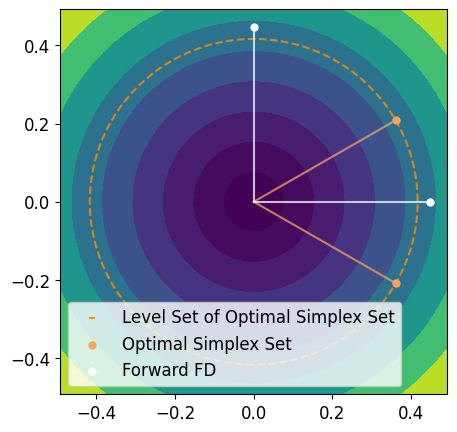

In [27]:
sig = 0.1
jrandom_key = jrandom.PRNGKey(0)

# l = loss_getter(2, 2, D, sig, coeff)
x_0 = jnp.zeros(2)
for a in [0.02, 1]: #jnp.logspace(-3, 1, 10):
    
    print(a)
    
    D = jnp.array([[a, 0], [0, 1]])
    
    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    F = Quadratic(D, b=jnp.zeros(2), c=0, sig=sig)
    
    l = get_mc_loss(F, x_0, 50)
    
    
    S_ours_getter = Ours(sig, max_h=float('inf'))
    S_FD_getter = FD(sig, is_central=False, h=None, use_H=True)
    
    gd_ours, _, _, _, S_ours = S_ours_getter.grad(F, x_0, subkey, H=F.f2(x_0))
    gd_FD, _, _, _, S_FD = S_FD_getter.grad(F, x_0, subkey, H=F.f2(x_0))

    scale, ellipse = create_ellipse(D, 100, S_ours[:, 0])
        
    print("MC ours", l(S_ours_getter, subkey))
    print("MC FD", l(S_FD_getter, subkey))
    
#     plt.scatter(ellipse[0], ellipse[1])



    lim = max([jnp.max(jnp.abs(ellipse)), jnp.max(jnp.abs(S_FD))*1.1])

    
    X = jnp.linspace(-lim, lim, 100)
    X, Y = jnp.meshgrid(X, X)
    XY = np.vstack([X.ravel(), Y.ravel()])
    Z = jnp.diag(XY.T @ D @ XY).reshape(X.shape[0], Y.shape[0])


    levels = [lev**2 for lev in jnp.linspace(0, jnp.sqrt(lim**2 + a * lim**2), 10)]
    
#     plt.contour(X, Y, Z, levels)

    plt.scatter(S_ours[0], S_ours[1], marker="_", color="darkorange", zorder=3, s=25, label="Level Set of Optimal Simplex Set")
    cp = plt.contourf(X, Y, Z, levels)
#     plt.colorbar(cp)
    


    
    plt.scatter(S_ours[0], S_ours[1], color="sandybrown", zorder=3, s=25, label="Optimal Simplex Set")
    plt.scatter(S_FD[0], S_FD[1], color="mintcream", zorder=3, s=25, label="Forward FD")
    
    plt.plot([0, S_ours[0, 0]], [0, S_ours[1, 0]], color="sandybrown", alpha=0.75, zorder=2)
    plt.plot([0, S_ours[0, 1]], [0, S_ours[1, 1]], color="sandybrown", alpha=0.75, zorder=2)

    
    plt.plot([0, S_FD[0, 0]], [0, S_FD[1, 0]], color="mintcream", alpha=0.75, zorder=2)
    plt.plot([0, S_FD[0, 1]], [0, S_FD[1, 1]], color="mintcream", alpha=0.75, zorder=2)
    
    plt.contour(X, Y, Z, levels=[scale], linestyles="dashed", alpha=0.8, colors=["darkorange"], zorder=1)





    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    
    plt.legend()


    plt.savefig("Figures/a_{}_sig_{}_2d_demo.jpeg".format(a, sig), dpi=500)
    plt.show()
    


In [41]:
help(plt.contour)

Help on function contour in module matplotlib.pyplot:

contour(*args, data=None, **kwargs)
    Plot contour lines.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == N`` is the number of columns in *Z* and
        ``len(Y) == M`` is the number of rows in *Z*.
    
        *X* and *Y* must both be ordered monotonically.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(N)``, ``Y = range(M)``.
    
    Z : (M, N) array-like
        The height values over which t

In [39]:
help(matplotlib.markers)

Help on module matplotlib.markers in matplotlib:

NAME
    matplotlib.markers

DESCRIPTION
    Functions to handle markers; used by the marker functionality of
    `~matplotlib.axes.Axes.plot`, `~matplotlib.axes.Axes.scatter`, and
    `~matplotlib.axes.Axes.errorbar`.
    
    All possible markers are defined here:
    
    ============================== ====== =========================================
    marker                         symbol description
    ============================== ====== =========================================
    ``"."``                        |m00|  point
    ``","``                        |m01|  pixel
    ``"o"``                        |m02|  circle
    ``"v"``                        |m03|  triangle_down
    ``"^"``                        |m04|  triangle_up
    ``"<"``                        |m05|  triangle_left
    ``">"``                        |m06|  triangle_right
    ``"1"``                        |m07|  tri_down
    ``"2"``                        |m

In [38]:
import matplotlib

# Create N-d plots

In [ ]:
sig = 0.1

dim = 32

jrandom_key = jrandom.PRNGKey(0)

x_0 = jnp.ones(dim)
res = []

a_range = jnp.logspace(-4, 4, 25)

num_MC = 50

for a in tqdm(a_range):
    D = np.eye(dim)
    D[0, 0] = a
    D = jnp.array(D)
    
    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    F = Quadratic(1/2 * D, jnp.zeros(dim), 0, sig=sig)
    
    l = get_mc_loss(F, x_0, num_MC)
    
    S_ours = Ours(sig, max_h=float("inf"))
    S_FD = FD(sig, is_central=False, h=float("inf"), use_H=True)

    res.append([l(S_ours, jrandom_key), l(S_FD, jrandom_key)])

    
res = jnp.array(res)




 72%|██████████████████████████████▉            | 18/25 [01:29<00:35,  5.14s/it]

In [ ]:
plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Condition Number")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_Error.jpeg".format(sig, num_MC, dim), dpi=500)

plt.show()



In [26]:
plt.rcParams['figure.figsize'] = [5,5]

In [19]:
!pip install turtle

  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /Users/daniellengyel/miniconda3/bin/python -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/c5/jntdg8g94vld91_h2df0psfc0000gn/T/pip-install-73t_boyg/turtle_1bcdd0d433ee40caa644249aa43bd7f0/setup.py'"'"'; __file__='"'"'/private/var/folders/c5/jntdg8g94vld91_h2df0psfc0000gn/T/pip-install-73t_boyg/turtle_1bcdd0d433ee40caa644249aa43bd7f0/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/c5/jntdg8g94vld91_h2df0psfc0000gn/T/pip-pip-egg-info-op3hx8br
       cwd: /private/var/folders/c5/jntdg8g94vld91_h2df0psfc0000gn/T/pip-install-73t_boyg/turtle_1bcdd0d433ee40caa644249aa43bd7f0/
  Complete output